In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2010-04-12,PPG,2010-04-12,68.7900,69.0300,68.56,68.89,27.2481,2705200,2.293912e+10
2009-08-26,X,2009-08-26,44.0000,44.2700,43.02,43.24,38.9001,13394510,5.966979e+09
2015-04-20,WU,2015-04-20,20.6900,20.8377,20.65,20.73,14.8398,3465810,1.083488e+10
2010-10-01,TTWO,2010-10-01,10.2500,10.3100,10.05,10.25,10.2500,1210891,1.073826e+09
2014-10-01,TSLA,2014-10-01,242.1999,242.6601,235.65,240.24,16.0160,89197646,4.547008e+11


In [6]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = ta.psar(df_ticker['high'],df_ticker['low'],df_ticker['close'],length = 20).fillna(0)
        metrics = metrics.iloc[:,0] - metrics.iloc[:,1]
        results[ticker] = metrics

    except :
        print(ticker)


100%|██████████| 866/866 [06:23<00:00,  2.26it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_20564\1610825839.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe                      1.1
Daily Turnover (%)         37.7
Average Daily pnl (bps)     1.5
dtype: float64

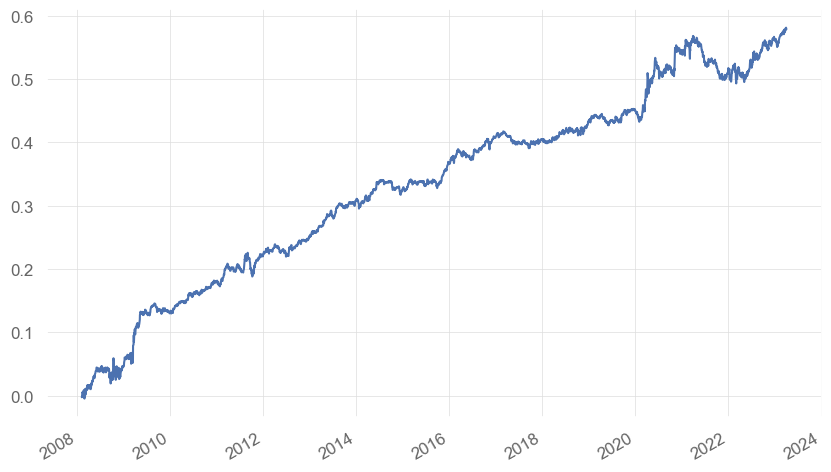

In [7]:
signal = pd.concat(results,axis=1).reindex_like(P).ffill()
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Daily Turnover (%)':turnover *100 ,'Average Daily pnl (bps)':PNL.mean()*1e4}).round(1)

<Axes: >

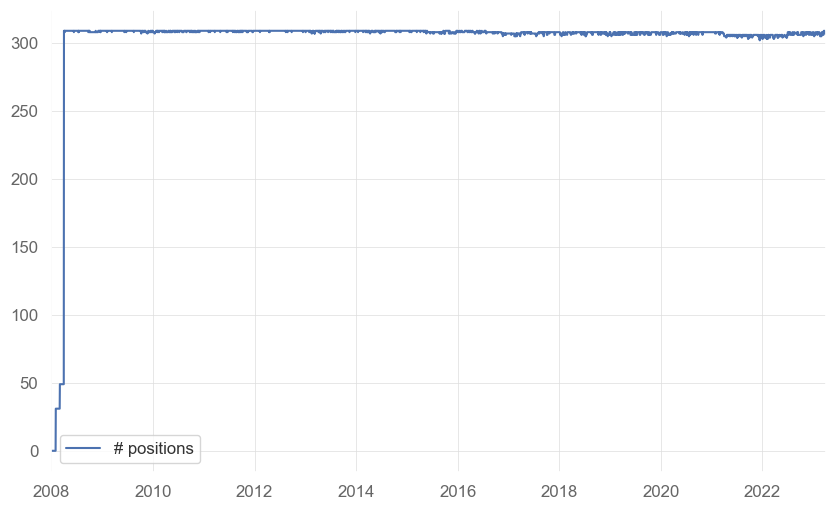

In [8]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

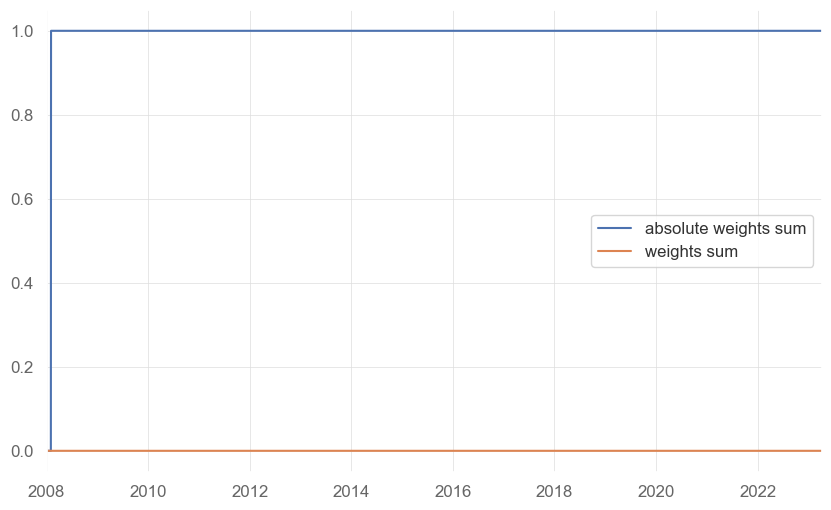

In [9]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)